In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

Global seed set to 0


# Read data from scvelo package

In [2]:
adata = scv.datasets.bonemarrow()

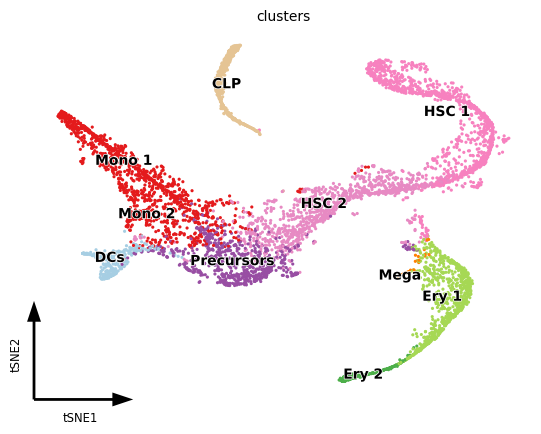

In [3]:
scv.pl.tsne(adata, color='clusters', frameon='artist')

# Setup data and train model

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
ltv.utils.standard_clean_recipe(adata)

Filtered out 7837 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.VAE(observed=2000, latent_dim=20, zr_dim=2, h_dim=2)

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='bonemarrow_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
494 velocity genes used
epoch 0, full loss 142.709, val loss 90.329, recon MSE 4.394, traj MSE 0.414, corr reg -2.593
epoch 1, full loss 45.646, val loss -21.992, recon MSE 3.139, traj MSE 0.384, corr reg -2.229
epoch 2, full loss 32.699, val loss -136.861, recon MSE 1.834, traj MSE 0.332, corr reg -1.749
epoch 3, full loss 102.865, val loss -247.237, recon MSE 1.456, traj MSE 0.322, corr reg -1.030
epoch 4, full loss 184.426, val loss -326.126, recon MSE 1.336, traj MSE 0.308, corr reg -0.769
epoch 5, full loss 257.964, val loss -376.957, recon MSE 1.173, traj MSE 0.303, corr reg -1.141
epoch 6, full loss 385.982, val loss -413.140, recon MSE 1.189, traj MSE 0.295, corr reg -0.908
epoch 7, full loss 456.498, val loss -434.882, recon MSE 1.100, traj MSE 0.296, corr reg -0.868
epoch 8, full loss 488.772, val loss -446.132, recon MSE 1.011, traj MSE 0.302, corr reg -0.950
epoch 9, full loss 484.428, val loss -453.534, rec

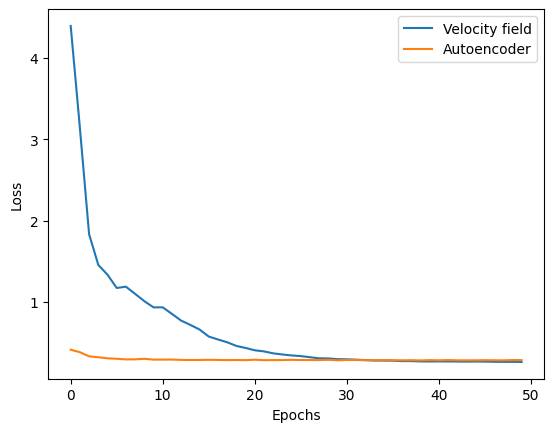

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute and plot velocity on tSNE

In [8]:
latent_adata = ltv.output_results(model, adata, embedding='tsne')

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


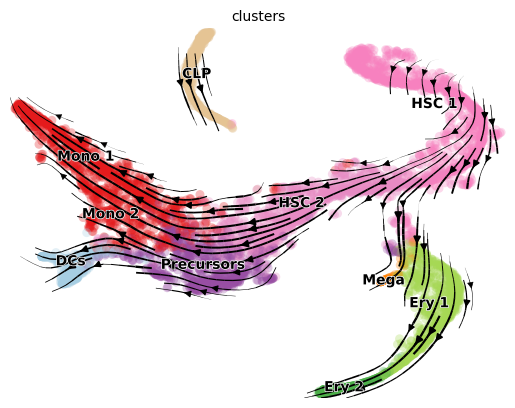

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity')

# Compute CBDir transition scores

In [11]:
bonemarrow_edges = [
    ('HSC_1', 'Mega'),
    ('HSC_1', 'Ery_1'), 
    ('Ery_1', 'Ery_2'),
    ('HSC_1', 'HSC_2'),
    ('HSC_2','Precursors'),
    ('HSC_2', 'Mono_2'),
    ('Mono_2', 'Mono_1'),
    ('Precursors','DCs')]

In [12]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
bonemarrow_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'clusters', 'spliced_velocity_pca', bonemarrow_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


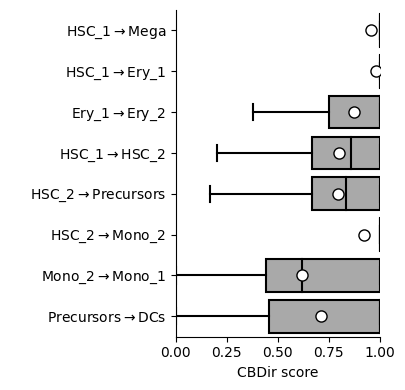

In [13]:
ax=ltv.pl.transition_scores(bonemarrow_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()

# Plot z_r scatter and compute lineage classification accuracy from z_r

Renamed 'zr' to convention 'X_zr' (adata.obsm).


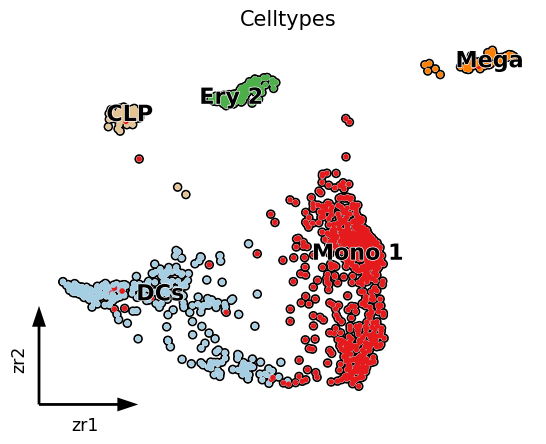

In [14]:
scv.pl.scatter(latent_adata[latent_adata.obs.clusters.isin(['Mega', 'Ery_2', 'Mono_1', 'DCs','CLP'])],
               'zr', color='clusters', frameon='artist', title='Celltypes', fontsize=15,
              legend_fontsize=16, add_outline=True)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

clf = LogisticRegression(penalty='none', max_iter=1e4)

data_= latent_adata[latent_adata.obs['clusters'].isin(['Mega', 'Ery_2', 'Mono_1', 'DCs','CLP'])].copy()

X = data_.obsm['zr']
y = LabelEncoder().fit_transform(data_.obs['clusters'].values)


pancreas_cvs = cross_val_score(clf, X, y, cv=25)

In [16]:
print('Prediction accuracy (2.5, 50, 97.5) percentiles:', np.percentile(pancreas_cvs, q=[2.5,50,97.5]))

Prediction accuracy (2.5, 50, 97.5) percentiles: [0.95405405 0.98648649 1.        ]


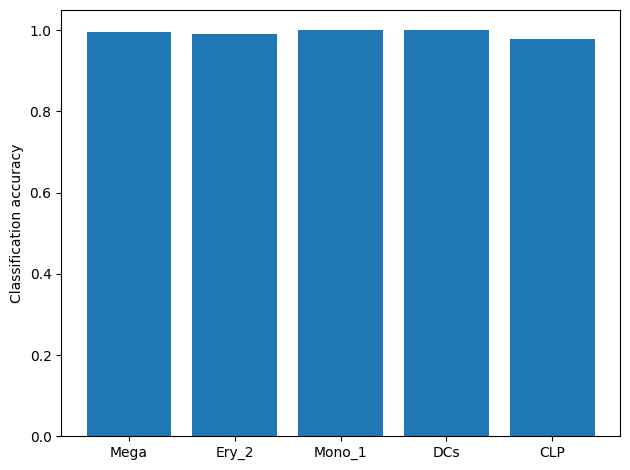

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
clf.fit(X, y)
pred = clf.predict(X)
class_accuracy = confusion_matrix(y, pred, normalize="true").diagonal()

fig, ax = plt.subplots()

plt.bar(x=['Mega', 'Ery_2', 'Mono_1', 'DCs','CLP'],height=class_accuracy)

ax.set(ylim=(0,1.05))
ax.set(ylabel='Classification accuracy')
plt.tight_layout()
plt.show()

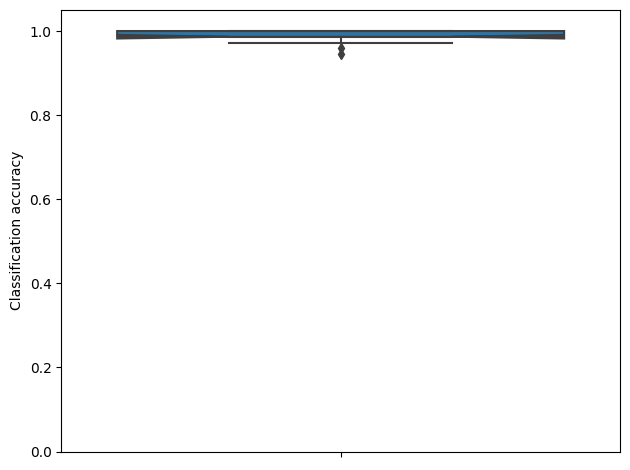

In [18]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

sns.boxplot(y=pancreas_cvs, ax=ax, notch=True)

ax.set(ylim=(0,1.05))
ax.set(ylabel='Classification accuracy')
plt.tight_layout()
plt.show()